# TESS lightcurve quicklook

Let's spot check the lightcurves for the sources that have been observed as of March 18, 2021: 
- UCAC2 7201471
- TYC 8534-1243-1 
- HD 49855 
- V* V479 Car 
- V* V1249 Cen (two out of five)

### Get the IGRINS epoch times.

In [1]:
%config Completer.use_jedi = False

In [2]:
import pandas as pd
import lightkurve as lk
from astropy.time import Time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
df_log = pd.read_csv('../../data/IGRINS/2021A_metadata_log.csv')

In [5]:
df_log.tail()

,night_dir,OBJECT,EXPTIME,BTJD
20,20210314,CD-62 657,30.0,2288.5974
21,20210314,V* V1249 Cen,30.0,2288.5647
22,20210314,V* V479 Car,30.0,2288.5460
23,20210316,V* V479 Car,30.0,2290.6759
24,20210317,V* V479 Car,30.0,2291.6196


In [6]:
df_log.OBJECT.value_counts()

UCAC2 7201471              6
TYC 8534-1243-1            5
HD 49855                   5
V* V479 Car                5
V* V1249 Cen               2
2MASS J12271665-6239142    1
CD-62 657                  1
Name: OBJECT, dtype: int64

Nice! At least 5 observations for all of these.  We don't have data from the most recent observing run yet, so we are missing log entries for:  
- V* V479 Car
- V* V1249 Cen (two out of five)

## TESS Lightcurves

In [7]:
btjd_now = Time.now().jd - 2457000.0
btjd_now

2748.125609667506

### UCAC2 7201471

In [8]:
object_name = 'UCAC2 7201471'
sr = lk.search_lightcurve(object_name, sector='35') # show 2 lightcurves? 34 & 35

In [9]:
sr = sr[0]

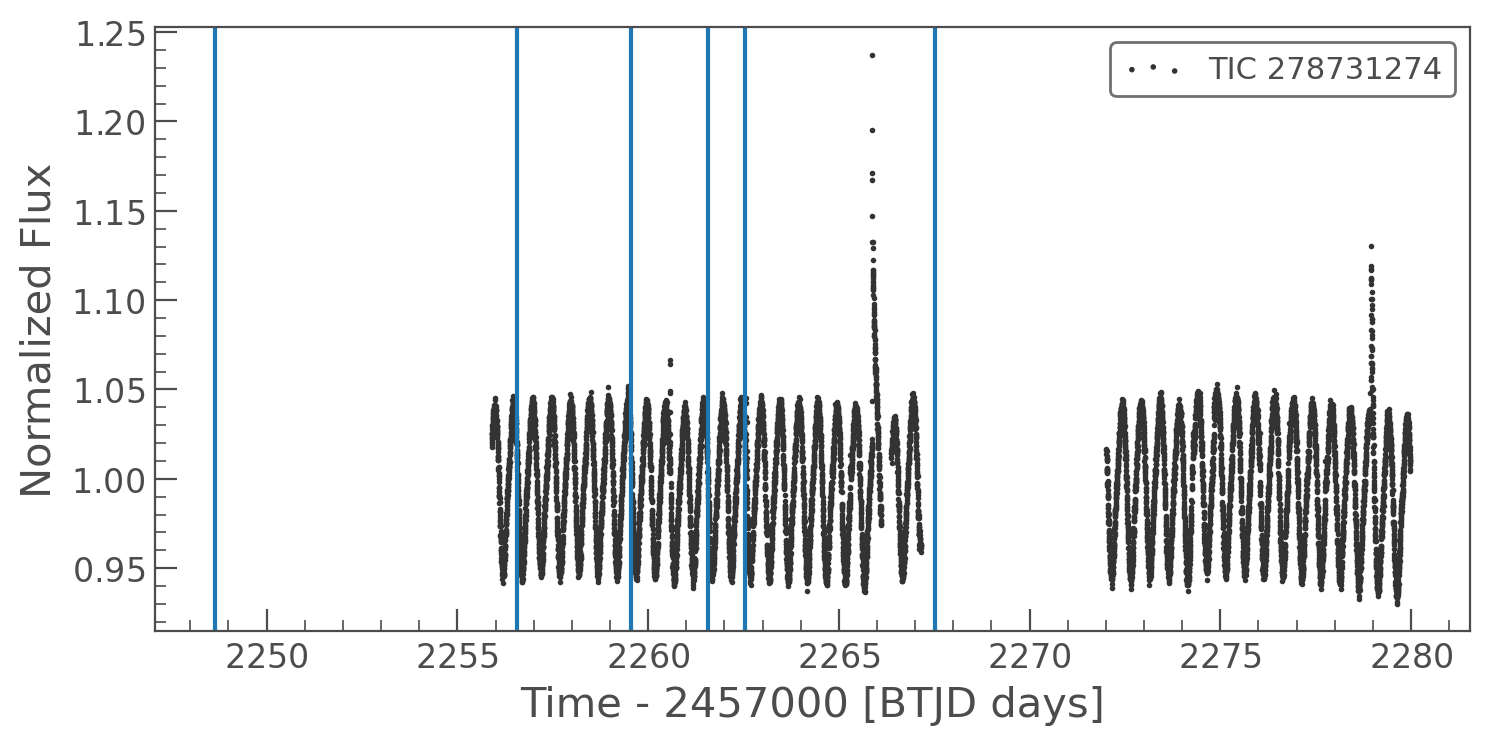

In [10]:
lc = sr.download().normalize()
obj_mask = df_log.OBJECT == object_name
epochs = df_log[obj_mask].BTJD.values
ax = lc.scatter();
for epoch in epochs:
    ax.axvline(epoch)

In [11]:
object_name = 'UCAC2 7201471'
sr = lk.search_lightcurve(object_name, sector=(34, 35), mission = 'TESS', exptime = 120) # show 2 lightcurves (34 & 35)

In [12]:
sr

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 34,2021,SPOC,120,278731274,0.0
1,TESS Sector 35,2021,SPOC,120,278731274,0.0


In [17]:
import seaborn as sns

In [18]:
sns.set_context('paper')

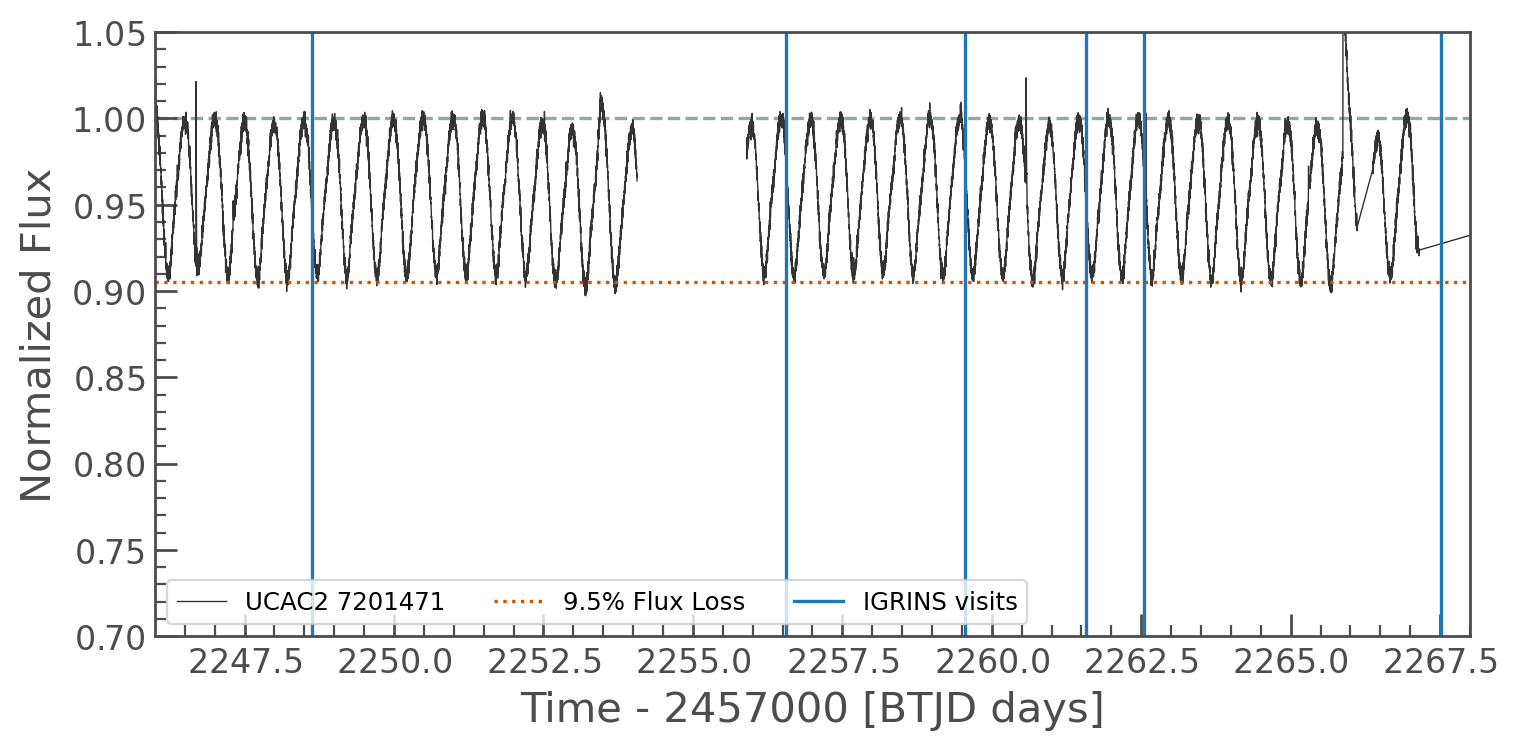

In [51]:
lc = sr.download_all()
lc_final = lc.stitch()
lc_final = lc_final/np.nanpercentile(lc_final.flux, 95)
obj_mask = df_log.OBJECT == object_name
epochs = df_log[obj_mask].BTJD.values
ax = lc_final.plot(label=object_name);
ax.axhline(1.0, linestyle = "dashed", color = "#95a5a6", label = None, zorder=0)
ax.axhline(0.905, linestyle = "dotted", color = "#d35400", label = "9.5% Flux Loss")

ax.axvline(epochs[0], label='IGRINS visits')
for epoch in epochs[1:]:
    ax.axvline(epoch, label=None)
    
ax.set_xlim(2246, 2268)
# ax.set_xlim(2262.25, 2263)
ax.set_ylim(0.7, 1.05)
#ax.set_title("UCAC2 7201471 Six IGRINS Visits")
plt.legend(loc="lower left", ncol=4)
plt.savefig("../../paper/paper1/figures/UCAC2_7201471_TESS_visits.png", dpi = 300, bbox_inches = "tight")

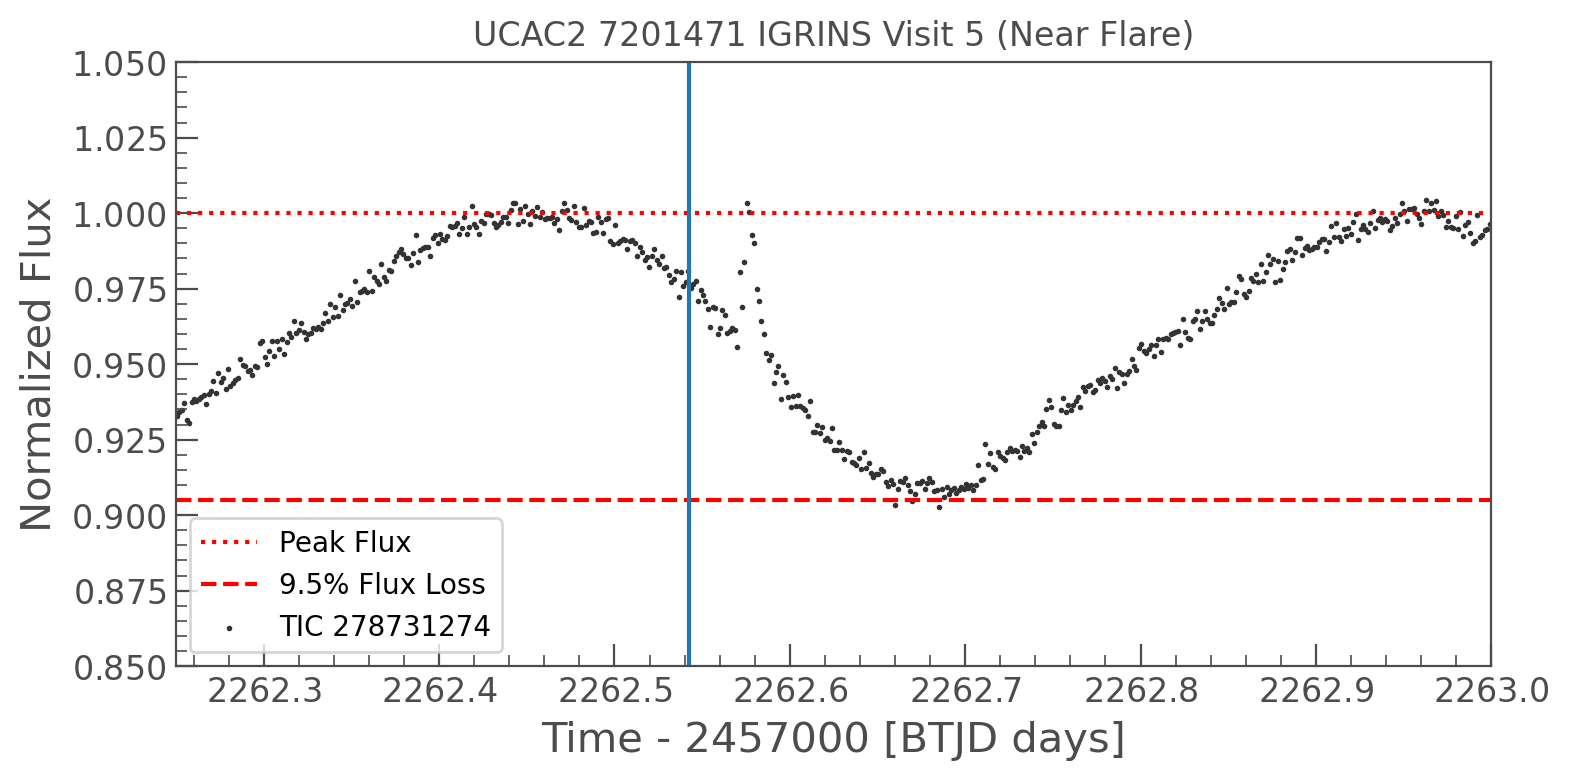

In [16]:
lc = sr.download_all()
lc_final = lc.stitch()
lc_final = lc_final/np.nanpercentile(lc_final.flux, 95)
obj_mask = df_log.OBJECT == object_name
epochs = df_log[obj_mask].BTJD.values
ax = lc_final.scatter();
ax.axhline(1.0, linestyle = "dotted", color = "red", label = "Peak Flux")
ax.axhline(0.905, linestyle = "dashed", color = "red", label = "9.5% Flux Loss")
ax.legend()
for epoch in epochs:
    ax.axvline(epoch)
# ax.set_xlim(2246, 2268)
ax.set_xlim(2262.25, 2263)
ax.set_ylim(0.85, 1.05)
ax.set_title("UCAC2 7201471 IGRINS Visit 5 (Near Flare)")
plt.savefig("../../figures/UCAC2_7201471_TESS_visit_5.png", dpi = 300, bbox_inches = "tight")

In [52]:
!open ../../figures

### TYC 8534-1243-1

In [ ]:
object_name = 'TYC 8534-1243-1'
sr = lk.search_lightcurve(object_name, sector='35', exptime=20)
lc = sr.download().normalize()
obj_mask = df_log.OBJECT == object_name
epochs = df_log[obj_mask].BTJD.values
ax = lc.plot();
for epoch in epochs:
    ax.axvline(epoch)

### HD 49855  

In [ ]:
object_name = 'HD 49855'
sr = lk.search_lightcurve(object_name, sector='34', exptime=120)
lc = sr.download().normalize()
obj_mask = df_log.OBJECT == object_name
epochs = df_log[obj_mask].BTJD.values
ax = lc.plot();
for epoch in epochs:
    ax.axvline(epoch)

### V* V479 Car  

In [ ]:
object_name = 'V* V479 Car'
sr = lk.search_tesscut(object_name)
sr

### V* V1249 Cen  

In [ ]:
object_name = 'V* V1249 Cen'
sr = lk.search_lightcurve(object_name)
sr

In [ ]:
lc = sr[0].download().normalize()
obj_mask = df_log.OBJECT == object_name
epochs = df_log[obj_mask].BTJD.values
ax = lc.plot(label='TESS Sector 10 (pending new sector!)');
for epoch in epochs:
    ax.axvline(epoch-700, label='IGRINS (Shifted by 700)')
plt.legend(loc='upper left')

### 2MASS J12271665-6239142

In [ ]:
object_name = '2MASS J12271665-6239142'
sr = lk.search_lightcurve(object_name)
sr

In [ ]:
lc = sr[0].download().normalize()
obj_mask = df_log.OBJECT == object_name
epochs = df_log[obj_mask].BTJD.values
ax = lc.plot(label='TESS Sector 11 (pending new sector!)');
for epoch in epochs:
    ax.axvline(epoch-670, label='IGRINS (Shifted by 700)')
plt.legend(loc='upper left');

### CD-62 657

In [ ]:
object_name = 'CD-62 657'
sr = lk.search_tesscut(object_name)
sr

## Early Release data products

TICA now offers [early release data products](https://heasarc.gsfc.nasa.gov/docs/tess/a-beta-trial-of-quick-look-tess-orbit-data-early-release-of-sector-35-orbit-1-calibrated-full-frame-images.html) through TICA full frame images.

There are two ways to try to access TICA:

- With tess-cloud, vis-a-vis the demo on [this GitHub Issue](https://github.com/lightkurve/lightkurve/issues/993)
- Download the full FFI frames yourself from the [TICA curl scripts](https://archive.stsci.edu/hlsp/tica)

Both of these strategies are not well-proven!  Let's use `tess-point` to get the coordinates.

### HD 49855

`python -m tess_stars2px -t 176873028`


|Sector | Camera | Ccd | ColPix | RowPix | EdgeWarn|
|--|--|--|--|--|--|
|35 | 4 | 1 | 1018.113608 | 2009.703572 | 0|

In [ ]:
from astropy.io import fits
import glob
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u

import numpy as np
import tqdm

In [ ]:
object_name = 'HD 49855'
sr = lk.search_lightcurve(object_name, sector='34', exptime=120)
lc = sr.download().normalize()

In [ ]:
lc.ticid

Ok, so we want camera 4, ccd 1.

In [ ]:
tica_fns = glob.glob('../../data/TESS/TICA/s0035/cam4-ccd1/*.fits')

In [ ]:
len(tica_fns)

### Generate a TPF with lightkurve:
We'll follow the tutorial I wrote (and apparently forgot about) here:  
https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-1-cutting-out-tpfs.html

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from lightkurve import TessTargetPixelFile
fnames = np.sort(tica_fns)
tpf = TessTargetPixelFile.from_fits_images(images_flux=fnames,
                                             position=SkyCoord(lc.RA, lc.Dec, unit='deg'),
                                             extension=0,
                                             size=(34,34))

Get a preliminary image to set the mask

In [ ]:
hdus = fits.open(tica_fns[123])

hdr = hdus[0].header

In [ ]:
time_btjd = hdr['MIDTJD']

In [ ]:
wcs = WCS(hdr)

In [ ]:
coord = SkyCoord(lc.RA*u.deg, lc.Dec*u.deg)

yc, xc = wcs.world_to_pixel(coord)
xc, yc = int(xc), int(yc)
yc, xc

Wow, really close to what TESS-point said!  Now stack all the data into a datacube:

In [ ]:
dw = 17

In [ ]:
times = []
data = []

In [ ]:
for i, fn in tqdm.tqdm(enumerate(tica_fns)):
    hdus = fits.open(fn)
    hdr = hdus[0].header
    times.append(hdr['MIDTJD'])
    
    img = hdus[0].data
    subimg = img[xc-dw:xc+dw, yc-dw:yc+dw]
    data.append(subimg)
    hdus.close()

In [ ]:
datacube = np.array(data)
times = np.array(times)
indices = times.argsort()
times = times[indices]
datacube = datacube[indices, :, :]

In [ ]:
median_frame = np.median(datacube, axis=0)

In [ ]:
lo, mediumlo, mid, hi = np.nanpercentile(median_frame, (1, 15, 50, 98))

In [ ]:
sr = lk.search_tesscut(target='HD 49855', sector=34)
sr

In [ ]:
tpf = sr.download(cutout_size=(34,34))

In [ ]:
tpf.plot(frame=500)

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(median_frame, origin='upper', vmin=lo, vmax=hi)

Ok, good spot-check, we are pointed at the right thing!

In [ ]:
vec = np.arange(34)
xx, yy = np.meshgrid(vec, vec)
dist = np.hypot(xx-17, yy-17)

In [ ]:
aperture_mask = (median_frame > hi) & (dist < 5)

In [ ]:
bkg_mask = (median_frame < mediumlo) & (dist > 9)

In [ ]:
n_ap = np.sum(aperture_mask)

In [ ]:
n_bkg = np.sum(bkg_mask)

In [ ]:
flux = np.sum(datacube*aperture_mask, axis=(1,2)) - np.sum(datacube*bkg_mask, axis=(1,2))/n_bkg*n_ap

In [ ]:
lc_tica = lk.LightCurve(time=times, flux=flux).normalize().remove_outliers()

In [ ]:
object_name = 'HD 49855'
sr = lk.search_lightcurve(object_name, sector='34', exptime=120)
lc = sr.download().normalize()
obj_mask = df_log.OBJECT == object_name
epochs = df_log[obj_mask].BTJD.values
ax = lc.plot(label='Sector 34 SPOC');

lc_tica.plot(ax=ax, label = 'Sector 35 Orbit 1 custom TICA', color='#e67e22', lw=2);

for epoch in epochs:
    ax.axvline(epoch)
    
plt.title(f"IGRINS 2021A with TESS Monitoring: {object_name} ")
    
plt.savefig('../../results/plots/HD_49855_TESS_TICA_S35_IGRINS.png',
           dpi=300, bbox_inches='tight')

Neat! We achieved our goal!  We see that we sampled at least a high and low phase, so that's a win.